## Model - Neural Network
* Feed-Forward Neural Network

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,LayerNormalization,Normalization
from tensorflow.keras import utils as np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks as c
from tensorflow.keras import regularizers

sns.set_style('whitegrid') # set style for visualization
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/engineered_features.csv', encoding='utf-8')
df

,SUBJECT_ID,SESSION_ID,TRIAL_ID,c_ml_min_r,c_ml_max_r,c_ml_min_l,c_ml_max_l,c_ap_slope_r,c_ap_slope_l,g_ml_max1_r,...,g_v_min_l,g_v_max2_l,diff_v1,diff_v2,diff_ap1,diff_ap2,AGE,BMI,CLASS_LABEL,SPEED
0,510,413,1,0.087271,0.118247,0.087814,0.128115,0.001718,0.002493,0.072643,...,0.796622,1.003385,0.425223,0.260852,0.096354,0.057032,47,35.538442,C,2
1,510,413,2,0.085806,0.128396,0.040212,0.083074,0.001589,0.001834,0.072360,...,0.837006,0.999401,0.322656,0.272089,0.071507,0.056424,47,35.538442,C,2
2,510,413,3,0.073788,0.112735,0.049990,0.099952,0.001740,0.001734,0.059417,...,0.815221,1.003578,0.298372,0.244674,0.054891,0.057072,47,35.538442,C,2
3,510,413,4,0.056216,0.102832,0.086729,0.127982,0.001919,0.001361,0.079792,...,0.773203,1.021851,0.316671,0.290747,0.072747,0.063221,47,35.538442,C,2
4,510,413,6,0.064922,0.102404,0.000573,0.052266,0.001837,0.002049,0.059537,...,0.820851,1.027245,0.374801,0.332217,0.116513,0.083453,47,35.538442,C,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43619,93,999910373,7,-0.019602,-0.001001,0.103706,0.140610,0.001320,0.001493,0.035459,...,0.776455,1.163370,0.134546,0.079414,0.046175,0.027730,53,21.651307,HC,2
43620,93,999910373,8,0.053761,0.060738,-0.024844,-0.006204,0.001334,0.002134,0.046960,...,0.753378,1.144916,0.159847,0.284077,0.038476,0.128401,53,21.651307,HC,2
43621,93,999910373,9,0.043214,0.068197,0.038681,0.053585,0.001676,0.001885,0.047020,...,0.764046,1.153042,0.180381,0.065231,0.071944,0.036908,53,21.651307,HC,2
43622,93,999910373,10,0.049181,0.060193,-0.036239,-0.007429,0.002073,0.001640,0.026953,...,0.779464,1.158905,0.149181,0.245195,0.031198,0.115095,53,21.651307,HC,2


In [3]:
df.isna().sum().loc[lambda x : x>0].sort_values(ascending=False)

Series([], dtype: int64)

In [4]:
df.shape

(43624, 33)

In [5]:
df.columns

Index(['SUBJECT_ID', 'SESSION_ID', 'TRIAL_ID', 'c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l', 'diff_v1', 'diff_v2', 'diff_ap1', 'diff_ap2', 'AGE',
       'BMI', 'CLASS_LABEL', 'SPEED'],
      dtype='object')

### Neural Network using 27 engineered features

Steps to improve NN accuracy via Keras API used: 
* https://keras.io/api/layers
* https://towardsdatascience.com/explainable-deep-neural-networks-2f40b89d4d6f
* https://stackoverflow.com/questions/58869736/is-it-safe-to-use-the-same-initializer-regularizer-and-constraint-for-multiple
* Model : Sequential
* Pre-processing layer: Normalization
* Input layer: Dense, Relu activation
* Hidden layer: Dense, ReLu activation with regularisation
* Regularisation layer: Dropout
* Output layer: Dense, Softmax activation

ReLUs is chosen over sigmoid as it mitigates the vanishing gradient issues when more layers are added.
* Info: https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks

Choosing number of hidden layers and number of units in Feed-forward neural network:
* Number of hidden layers equals one
* Number of neurons in that layer is the mean of the neurons in the input and output layers. (24+5)/2 ~ 15
* Reference: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

Choose epoch and batch size:
* https://datascience.stackexchange.com/questions/32306/in-which-epoch-should-i-stop-the-training-to-avoid-overfitting
* https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

Types of keras NN models:
* https://www.kaggle.com/code/yasserh/tutorial-on-types-of-keras-models
* Dropout layer removed for first model as it reduces the accuracy

In [6]:
factorised_labels, original_labels = df['CLASS_LABEL'].factorize()
print(factorised_labels)
print(original_labels)

[0 0 0 ... 4 4 4]
Index(['C', 'K', 'H', 'A', 'HC'], dtype='object')


In [7]:
features = ['c_ml_min_r', 'c_ml_max_r',
       'c_ml_min_l', 'c_ml_max_l', 'c_ap_slope_r', 'c_ap_slope_l',
       'g_ml_max1_r', 'g_ml_min_r', 'g_ml_max2_r', 'g_ml_max1_l', 'g_ml_min_l',
       'g_ml_max2_l', 'g_ap_min_r', 'g_ap_max_r', 'g_ap_min_l', 'g_ap_max_l',
       'g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l','diff_v1', 'diff_v2', 'diff_ap1', 'diff_ap2', 'AGE',
       'BMI']

selected = ['g_v_max1_r', 'g_v_min_r', 'g_v_max2_r', 'g_v_max1_l', 'g_v_min_l',
       'g_v_max2_l','diff_v1', 'diff_v2', 'diff_ap1', 'diff_ap2', 'AGE',
       'BMI']

In [8]:
#prepare the data
X= df[features]
y = np_utils.to_categorical(factorised_labels)
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [10]:
X_train.shape

(32718, 28)

In [11]:
#create normalisation layer and set initial state using training data
normalization_layer = Normalization()
normalization_layer.adapt(X_train)

#Callbacks: early stopping
callback = c.EarlyStopping(monitor='loss', patience=3)

#Dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_dim = round((input_dim+output_dim)/2)

#Add layers to sequential model
model = Sequential()
model.add(normalization_layer)
model.add(Dense(input_dim, activation='relu',kernel_initializer='random_normal')) 
model.add(Dense(hidden_dim, activation='relu',kernel_initializer='random_normal',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(output_dim, activation='softmax',kernel_initializer='random_normal'))
model.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28)               57        
 n)                                                              
                                                                 
 dense (Dense)               (None, 28)                812       
                                                                 
 dense_1 (Dense)             (None, 16)                464       
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,418
Trainable params: 1,361
Non-trainable params: 57
_________________________________________________________________


In [12]:
%%time
# Fit the model and save into history
history = model.fit(X_train, y_train, batch_size=100, epochs=100, validation_data=(X_test, y_test),verbose=0,callbacks=[callback])

CPU times: total: 28.4 s
Wall time: 1min 40s


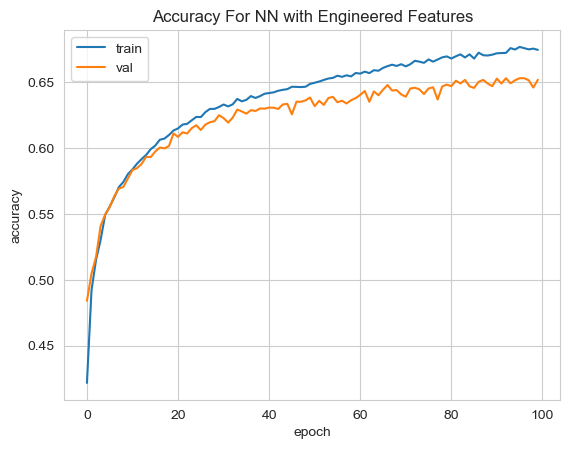

In [13]:
#plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy For NN with Engineered Features')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
#Predict
pred_labels = np.argmax(model.predict(X_test),axis=1)
pred_labels

341/341 [==============================] - 1s 2ms/step


array([2, 4, 0, ..., 1, 1, 2], dtype=int64)

In [15]:
y_test_labels=np.argmax(y_test,axis=1)
y_test_labels

array([2, 4, 0, ..., 1, 1, 2], dtype=int64)

In [16]:
accuracy_score(y_test_labels,pred_labels)

0.6515679442508711

In [17]:
#Create confusion matrix
cm = confusion_matrix(y_test_labels, pred_labels)
print(cm)

[[1385  132   23  353   11]
 [  99 1871  257  508  109]
 [  74  392  948  154   67]
 [ 491  557  152 2589   74]
 [  10  147   71  119  313]]


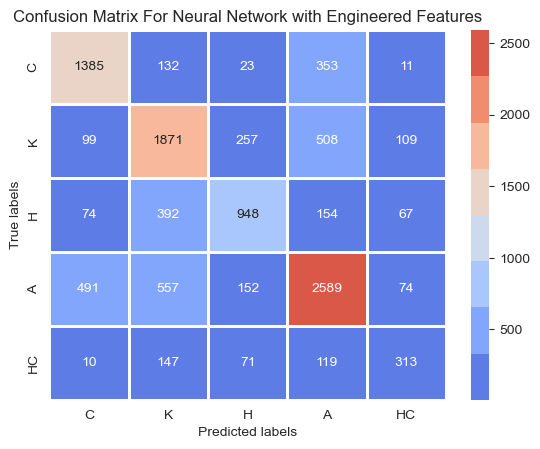

In [18]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("coolwarm", 8), linewidths=1, linecolor='w');

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Neural Network with Engineered Features'); 
ax.xaxis.set_ticklabels(original_labels); 
ax.yaxis.set_ticklabels(original_labels);

In [19]:
def confusion_matrix_metrics(cls, cm):
    TP = cm[cls, cls]
    FN = cm[cls].sum() - TP
    FP = cm[:, cls].sum() - TP
    TN = cm.sum() - TP - FN - FP
    return np.array([[TP, FN], [FP, TN]])

In [20]:
for cls in range(cm.shape[0]):
    print(f'[Class {original_labels[cls]} vs others]')
    TP, FN, FP, TN = confusion_matrix_metrics(cls, cm).ravel()
    print(f'TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}')

[Class C vs others]
TP: 1385, FN: 519, FP: 674, TN: 8328
[Class K vs others]
TP: 1871, FN: 973, FP: 1228, TN: 6834
[Class H vs others]
TP: 948, FN: 687, FP: 503, TN: 8768
[Class A vs others]
TP: 2589, FN: 1274, FP: 1134, TN: 5909
[Class HC vs others]
TP: 313, FN: 347, FP: 261, TN: 9985


In [21]:
print(classification_report(y_test_labels, pred_labels,target_names=original_labels))

              precision    recall  f1-score   support

           C       0.67      0.73      0.70      1904
           K       0.60      0.66      0.63      2844
           H       0.65      0.58      0.61      1635
           A       0.70      0.67      0.68      3863
          HC       0.55      0.47      0.51       660

    accuracy                           0.65     10906
   macro avg       0.63      0.62      0.63     10906
weighted avg       0.65      0.65      0.65     10906



**Findings**
* A, C, H, HC, K
* macro avg is the average of the precision / recall for all classes
* For prediction, we aim to reduce false nagative to capture all walking issues, hence recall is chaosen to be more important metric
* Support is the number of actual occurrences of the class in the specified dataset, the class distribution is not too imbalanced towards class 1 and 3

## Neural Network using original 1000 features

In [22]:
df2 = pd.read_csv('../data/original_features.csv', encoding='utf-8')
df2

,SUBJECT_ID,SESSION_ID,TRIAL_ID,0_cmlr,1_cmlr,2_cmlr,3_cmlr,4_cmlr,5_cmlr,6_cmlr,...,94_gvl,95_gvl,96_gvl,97_gvl,98_gvl,99_gvl,AGE,BMI,SPEED,CLASS_LABEL
0,510,413,1,0.090489,0.088296,0.090543,0.088585,0.088419,0.087271,0.087643,...,0.206161,0.157969,0.114536,0.078322,0.051086,0.030038,47,35.538442,2,C
1,510,413,2,0.099445,0.085806,0.092521,0.089278,0.092119,0.090495,0.091194,...,0.193967,0.150712,0.109526,0.073994,0.048843,0.028040,47,35.538442,2,C
2,510,413,3,0.080434,0.073788,0.076158,0.074499,0.074923,0.074800,0.075813,...,0.207438,0.159884,0.116295,0.077046,0.050402,0.028532,47,35.538442,2,C
3,510,413,4,0.072603,0.056216,0.062936,0.058685,0.061489,0.060092,0.061455,...,0.200746,0.153727,0.111913,0.075615,0.050814,0.029449,47,35.538442,2,C
4,510,413,6,0.076400,0.064922,0.069484,0.067106,0.067142,0.065643,0.066555,...,0.226931,0.175726,0.127687,0.084625,0.054879,0.030352,47,35.538442,2,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70611,93,999910373,7,-0.017693,-0.014078,-0.019602,-0.018559,-0.016351,-0.017482,-0.013853,...,0.244534,0.164482,0.076021,0.066762,0.031144,0.058902,53,21.651307,2,HC
70612,93,999910373,8,0.058477,0.057364,0.055491,0.053761,0.055107,0.055427,0.056744,...,0.526146,0.406308,0.281442,0.175061,0.087550,0.043759,53,21.651307,2,HC
70613,93,999910373,9,0.064663,0.052117,0.043214,0.058298,0.049768,0.055759,0.054642,...,0.495094,0.389999,0.274723,0.182228,0.093029,0.050763,53,21.651307,2,HC
70614,93,999910373,10,0.060062,0.055547,0.049181,0.050987,0.052540,0.053151,0.054697,...,0.480650,0.360813,0.241422,0.147052,0.071328,0.043721,53,21.651307,2,HC


In [23]:
df2.dropna(inplace=True)

In [24]:
df2.isna().sum().loc[lambda x : x>0].sort_values(ascending=False)

Series([], dtype: int64)

In [25]:
#prepare the data
X= df2.drop(['SUBJECT_ID','SESSION_ID','TRIAL_ID','SPEED','CLASS_LABEL'],axis=1)
y= np_utils.to_categorical(df2['CLASS_LABEL'].factorize()[0])
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

In [27]:
X_train.shape

(32718, 1002)

In [28]:
#create normalisation layer and set initial state using training data
normalization_layer = Normalization()
normalization_layer.adapt(X_train)

#Callbacks: early stopping
callback = c.EarlyStopping(monitor='loss', patience=3)

#Dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_dim = round((input_dim+output_dim)/2)

#Add layers to sequential model
model2 = Sequential()
model2.add(normalization_layer)
model2.add(Dense(input_dim, activation='relu',kernel_initializer='random_normal'))
model2.add(Dense(hidden_dim, activation='relu',kernel_initializer='random_normal', kernel_regularizer='l2'))
model2.add(Dropout(.5))
model2.add(Dense(output_dim, activation='softmax',kernel_initializer='random_normal'))
model2.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1002)             2005      
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 1002)              1005006   
                                                                 
 dense_4 (Dense)             (None, 504)               505512    
                                                                 
 dropout (Dropout)           (None, 504)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 2525      
                                                                 
Total params: 1,515,048
Trainable params: 1,513,043
Non-trainable params: 2,005
________________________________________

In [29]:
%%time
# Fit the model and save into history
history2 = model2.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_test, y_test),verbose=0,callbacks=[callback])

CPU times: total: 3min 54s
Wall time: 5min 26s


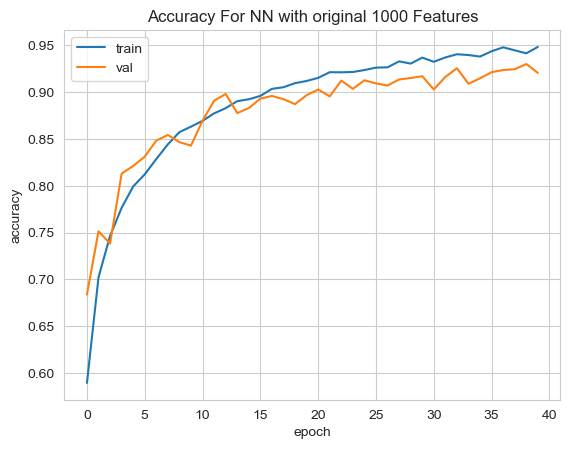

In [30]:
#plot
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Accuracy For NN with original 1000 Features')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
#Predict
pred_labels_2 = np.argmax(model2.predict(X_test),axis=1)
pred_labels_2

341/341 [==============================] - 2s 6ms/step


array([2, 4, 0, ..., 1, 1, 2], dtype=int64)

In [32]:
y_test_labels_2=np.argmax(y_test,axis=1)
y_test_labels_2

array([2, 4, 0, ..., 1, 1, 2], dtype=int64)

In [33]:
accuracy_score(y_test_labels_2,pred_labels_2)

0.9206858609939483

In [34]:
#Create confusion matrix
cm_2 = confusion_matrix(y_test_labels_2, pred_labels_2)
print(cm_2)

[[1822    5   12   65    0]
 [  22 2578   50  181   13]
 [  24   47 1465   93    6]
 [  85   71   30 3671    6]
 [   4   36   33   82  505]]


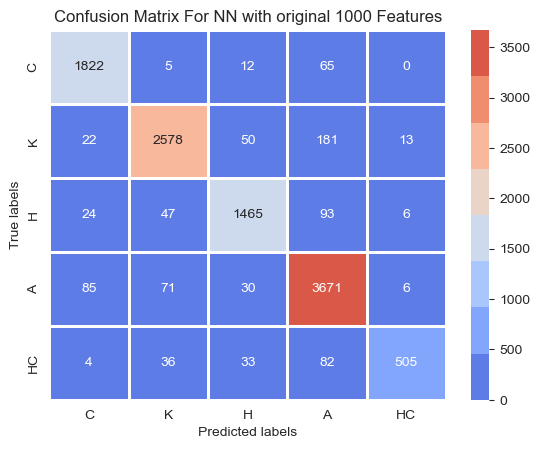

In [35]:
ax= plt.subplot()
sns.heatmap(cm_2, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("coolwarm", 8), linewidths=1, linecolor='w');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For NN with original 1000 Features'); 
ax.xaxis.set_ticklabels(original_labels); 
ax.yaxis.set_ticklabels(original_labels);

In [36]:
for cls in range(cm_2.shape[0]):
    print(f'[Class {original_labels[cls]} vs others]')
    TP, FN, FP, TN = confusion_matrix_metrics(cls, cm_2).ravel()
    print(f'TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}')

[Class C vs others]
TP: 1822, FN: 82, FP: 135, TN: 8867
[Class K vs others]
TP: 2578, FN: 266, FP: 159, TN: 7903
[Class H vs others]
TP: 1465, FN: 170, FP: 125, TN: 9146
[Class A vs others]
TP: 3671, FN: 192, FP: 421, TN: 6622
[Class HC vs others]
TP: 505, FN: 155, FP: 25, TN: 10221


In [37]:
print(classification_report(y_test_labels_2, pred_labels_2, target_names=original_labels))

              precision    recall  f1-score   support

           C       0.93      0.96      0.94      1904
           K       0.94      0.91      0.92      2844
           H       0.92      0.90      0.91      1635
           A       0.90      0.95      0.92      3863
          HC       0.95      0.77      0.85       660

    accuracy                           0.92     10906
   macro avg       0.93      0.89      0.91     10906
weighted avg       0.92      0.92      0.92     10906



**Findings**
* The accuracy is better using the original sensor readings of 1000 data points as features for each participant / trial